In [2]:
from pathlib import Path
import pandas as pd
import sys
import pickle
import json

# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))
from configs.path_config import EXTRACTED_DATA_DIR, OUTPUT_DIR
from configs.support_coords import *

from src.clustering import clustering_preprocess #load_data, drop_columns_by_header_rules, remove_outliers, explain_variance, do_pca
from src.clustering import clustering_models # kmeans_clustering, gmm_clustering, kl_divergence, jeffreys_divergence, merge_clusters_by_divergence, streaming_dpgmm_clustering
from src.clustering import clustering_visualization #plot_clusters_over_time, plot_cluster_mean_and_std
from src.clustering import sankey_diagram #plot_sankey_diagram

C:\Users\hpl886\Documents\Exjobb


### Data loading and preprocessing


In [ ]:
path = EXTRACTED_DATA_DIR / 'strain_distributions' / 'alvbrodel_04' / 'S-C_Close_Comp_20091129120000_20210611160000_strain_distribution_04.csv'
# path = OUTPUT_DIR / 'strain_distributions' / 'N-F_Mid_Comp_20091129120000_20210611160000_strain_distribution.csv'
df = clustering_preprocess.load_data(path)
# df

In [ ]:
df = clustering_preprocess.drop_columns_by_header_rules(df, threshold=0)
# df

In [ ]:
df_strain, df = clustering_preprocess.remove_outliers(df, threshold=7, individual_threshold=7)
# df

Total number of outliers removed: 608


### Explained Variance by Number of Prinicipal Components 

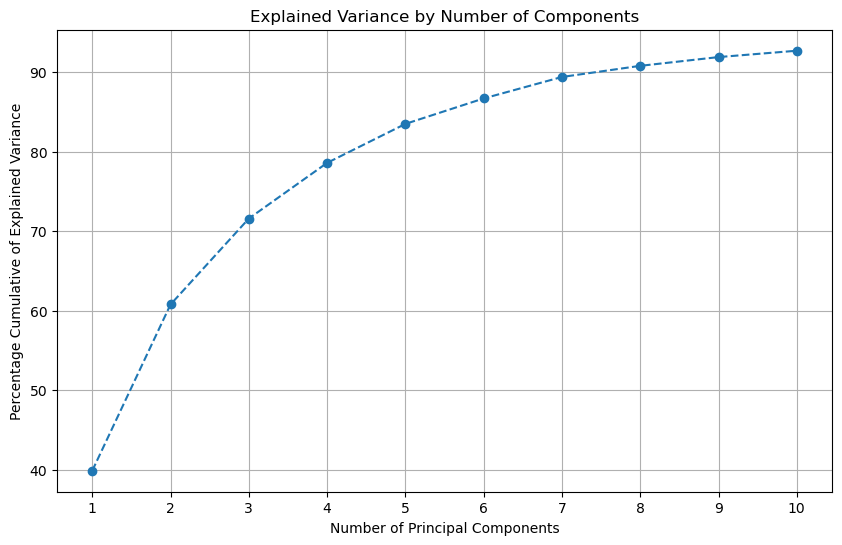

In [ ]:
clustering_preprocess.explain_variance(df_strain)

In [ ]:
n_components = 8
normalized_pca_components, df_pca = clustering_preprocess.do_pca(n_components, df_strain, df)

### GMM Clustering

In [ ]:
# n_clusters = 10
# data_with_gmm, cluster_color_map  = clustering_models.gmm_clustering(normalized_pca_components, df, n_clusters)
# data_with_gmm

In [ ]:
# clustering_visualization.plot_clusters_over_time(data_with_gmm, cluster_color_map, 'GMM')

In [ ]:
# clusters_to_keep = ['all'] # 'all' or a list of cluster indices
# clustering_visualization.plot_cluster_mean_and_std(data_with_gmm, clusters_to_keep, cluster_color_map, 'GMM')

### DPGMM Clustering

In [3]:
save_dir = OUTPUT_DIR / 'strain_distributions' / 'DPGMM' / 'C_test'
name = "C_clustering_results.pkl"
path = save_dir / name

In [ ]:
data_with_dpgmm, cluster_color_map, cluster_dict, normalized_pca_components, all_labels = clustering_models.streaming_dpgmm_clustering(
    normalized_pca_components=normalized_pca_components,
    df=df,
    prior=0.1,                # Decides how restrictive the model is when creating new clusters the lower the more restrictive
    n_points=1095,            # Number of points to use for the initial clustering, 3 years
    window_size=180,          # Size of the sliding window, 0,5 years
    step_size=90,             # Step size for the sliding window, 3 months
    max_components=100,       # Maximum number of components to use in the model
    merge_threshold=7,        # Threshold for merging clusters
)

clustering_results = {
    "data_with_dpgmm": data_with_dpgmm,
    "cluster_color_map": cluster_color_map,
    "cluster_dict": cluster_dict,
    "normalized_pca_components": normalized_pca_components,
    "all_labels": all_labels
}

with open(path, 'wb') as outf:
    pickle.dump(clustering_results, outf)

c:\Users\hpl886\AppData\Local\anaconda3\envs\exjobb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Initial fit => Clusters used: 1


c:\Users\hpl886\AppData\Local\anaconda3\envs\exjobb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Window 1095-1275 => Active clusters in window: 2, Unique clusters in window: [0 1], Top 5 weights: [0.002 0.001 0.002 0.001 0.001]
Window 1185-1365 => Active clusters in window: 2, Unique clusters in window: [0 1], Top 5 weights: [0.001 0.001 0.146 0.001 0.002]
Window 1275-1455 => Active clusters in window: 2, Unique clusters in window: [0 1], Top 5 weights: [0.001 0.001 0.115 0.001 0.002]
Window 1365-1545 => Active clusters in window: 2, Unique clusters in window: [0 1], Top 5 weights: [0.001 0.001 0.001 0.184 0.002]
Window 1455-1635 => Active clusters in window: 2, Unique clusters in window: [0 1], Top 5 weights: [0.051 0.001 0.001 0.001 0.001]
Window 1545-1725 => Active clusters in window: 1, Unique clusters in window: [1], Top 5 weights: [0.107 0.001 0.001 0.001 0.002]
Window 1635-1815 => Active clusters in window: 1, Unique clusters in window: [1], Top 5 weights: [0.001 0.085 0.001 0.043 0.001]
Window 1725-1905 => Active clusters in window: 1, Unique clusters in window: [1], Top 5

In [4]:
with open(path, 'rb') as f: 
    clustering_results_reload = pickle.load(f)

data_with_dpgmm = clustering_results_reload["data_with_dpgmm"]
cluster_color_map = clustering_results_reload["cluster_color_map"]
cluster_dict = clustering_results_reload["cluster_dict"]
normalized_pca_components = clustering_results_reload["normalized_pca_components"]
all_labels = clustering_results_reload["all_labels"]

### Visualize the Clusters

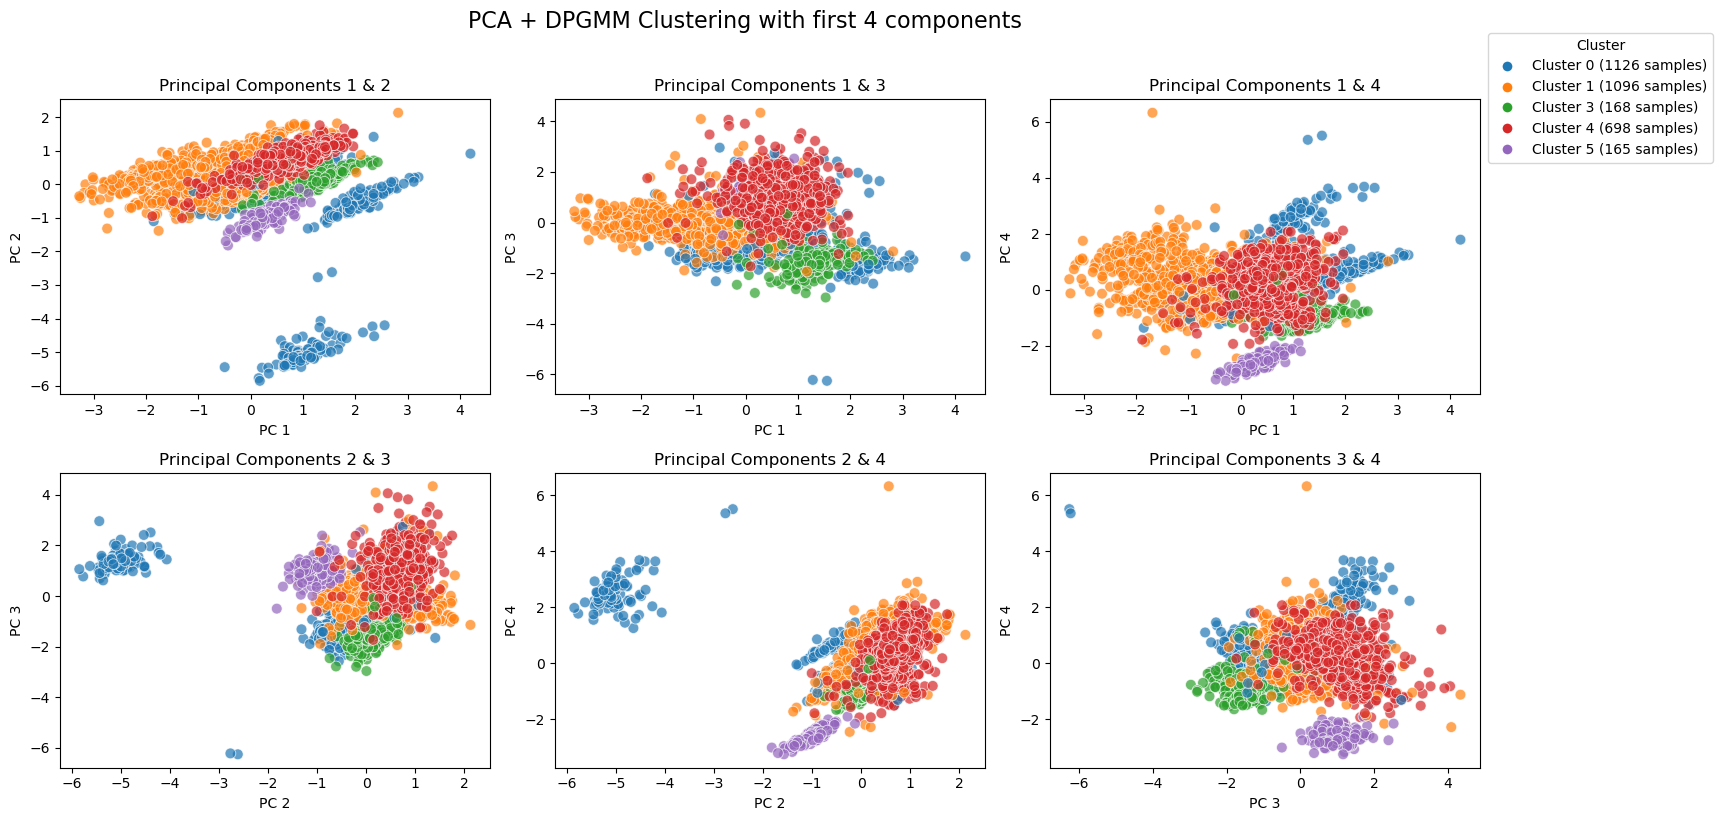

In [7]:
save_dir = OUTPUT_DIR / 'strain_distributions' / 'DPGMM' / 'C_test' / 'clusters.pdf'
clustering_visualization.plot_dpgmm_clusters(
    data_with_dpgmm,
    normalized_pca_components,
    all_labels,
    cluster_color_map, 
    num_components_to_plot=4,
    save_dir=save_dir,
    save=True)

### Plot the Cluster Assignment over Time

In [ ]:
name = "clusters_over_time_C.pdf"
save_path = save_dir / name
clustering_visualization.plot_clusters_over_time(data_with_dpgmm, cluster_color_map, 'DPGMM', save_path, save=True)

In [ ]:
new_data_with_dpgmm = data_with_dpgmm[data_with_dpgmm['Assigned_Cluster_Prob'] > 1e-2]
new_data_with_dpgmm.shape 

(3253, 1608)

### Cluster Visualization
Visualizes the representative strain distribution of each cluster in the form of mean strain (dark) and standard deviation of strain (light shade).

In [ ]:
clusters_to_keep = [0,7] # 'all' or a list of cluster indices
save_path = OUTPUT_DIR / 'strain_distributions' / 'DPGMM' / 'C_step_size_7' / "C_['0', '4']_mean_and_std.pdf"
beam = beam_C
clustering_visualization.plot_cluster_mean_and_std(data_with_dpgmm, clusters_to_keep, cluster_color_map, 'DPGMM', beam, save_dir, save=False)

### Plot Sankey Diagram
Visualizes trainsitions between and merges of clusters after each step of the sliding window in the clustering algorithm. 

In [ ]:
cluster_dict_converted = {
    pd.to_datetime(key, format="%Y-%m-%d").date(): value
    for key, value in cluster_dict.items()
}
# cluster_dict_converted = {
#     pd.to_datetime(k, format="%Y-%m-%d").date(): cluster_dict[k]
#     for i, k in enumerate(cluster_dict)
#     if i % 12 == 0
# }

links = sankey_diagram.build_sankey_links_from_cluster_dict(cluster_dict_converted)
nodes, source, target, value = sankey_diagram.prepare_sankey_data(links)

sankey_diagram.plot_sankey(
    nodes, 
    source,
    target, 
    value, 
    title="Cluster transitions over time (90 day intervals)", 
    save_path=OUTPUT_DIR / 'strain_distributions' / 'DPGMM' / "sankey_diagram_90_day_intervals.pdf", 
    save = True
)